In [1]:
%load_ext autoreload
%autoreload 2
%cd /workspace

/workspace


In [2]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0

### Aligning image

In [4]:
from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

from src.models.e4e import pSp


EXPERIMENT_ARGS = {
    "model_path": "saved/models/e4e_ffhq_encode.pt"
}
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: saved/models/e4e_ffhq_encode.pt
Model successfully loaded!


In [5]:
import dlib
from src.models.e4e.utils import align_face


def run_alignment(image_path):
    predictor = dlib.shape_predictor("saved/shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor) 
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image 


img1 = run_alignment(f'data/custom_images/zhzh.jpeg')
img2 = run_alignment(f'data/custom_images/baha.jpg')
tensor_img1 = EXPERIMENT_ARGS['transform'](img1)
tensor_img2 = EXPERIMENT_ARGS['transform'](img2)

tensor_img = torch.stack([tensor_img1, tensor_img2], dim=0)

Aligned image has shape: (256, 256)
Aligned image has shape: (256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


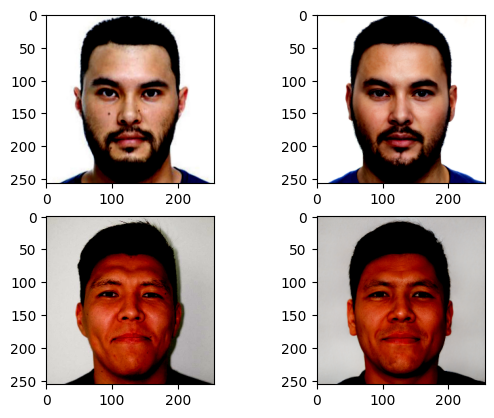

In [6]:
decoded, latent, style_vector = net(tensor_img.cuda(), randomize_noise=False, return_latents=True)
# decoded.shape, latent.shape, style_vector.__len__()

_, axs = plt.subplots(ncols=2, nrows=2)
axs[0][0].imshow(tensor_img[0].squeeze().permute(1, 2, 0))
axs[0][1].imshow(decoded[0].squeeze().permute(1, 2, 0).detach().cpu())
axs[1][0].imshow(tensor_img[1].squeeze().permute(1, 2, 0))
axs[1][1].imshow(decoded[1].squeeze().permute(1, 2, 0).detach().cpu())

# Manipulating using Global Directions

In [3]:
from src.models.styleclip.global_directions import StyleCLIPInferencer

inferencer = StyleCLIPInferencer(
    'saved/stylegan2/ffhq.pkl',
    'saved/stylegan2/fs3.npy',
    "ViT-B/32",
    device=torch.device('cuda:1'),
    alpha=3,
    beta=0.13
)

name:conv1_resolution_4 Resolution: 4, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_4 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_8 Resolution: 8, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_8 Resolution: 8, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_8 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_16 Resolution: 16, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_16 Resolution: 16, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_16 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_32 Resolution: 32, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_32 Resolution: 32, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_32 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_64 Resolution: 64, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_64 Resolution: 64, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_64 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_128 Resolution: 128, InC: 512, OutC:256, w_dim: 512
name:conv1_resol

## batched inference

In [4]:
import torch
import numpy as np

w_latents = np.load('data/wspace_ffhq_feat.npy')

In [5]:
w_latents.shape

(70000, 18, 512)

In [38]:
example_latent = torch.from_numpy(w_latents[:4, :, :])

In [39]:
example_latent.shape

torch.Size([4, 18, 512])

In [49]:
s_latent = inferencer.manipulator.G.synthesis.W2S(example_latent.cuda())

In [69]:
s_latent['conv1_resolution_4'].device

device(type='cuda', index=1)

In [50]:
codes = [
    code.reshape(example_latent.shape[0], 1, -1) for code in inferencer.manipulator.S2List(s_latent)
]

In [51]:
codes.__len__(), codes[2].shape

(26, (4, 1, 512))

In [57]:
codes[0][:, 0].shape

(4, 512)

In [59]:
encoded_styles = {}

for i in range(len(inferencer.manipulator.s_names)):
    encoded_styles[inferencer.manipulator.s_names[i]] = torch.from_numpy(codes[i].squeeze(1)).cuda()

In [61]:
encoded_styles['conv1_resolution_4'].shape

torch.Size([4, 512])

In [62]:
with torch.no_grad():
    imgs = inferencer.manipulator.G.synthesis(
        None, encoded_styles=encoded_styles, noise_mode="const"
    ).detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


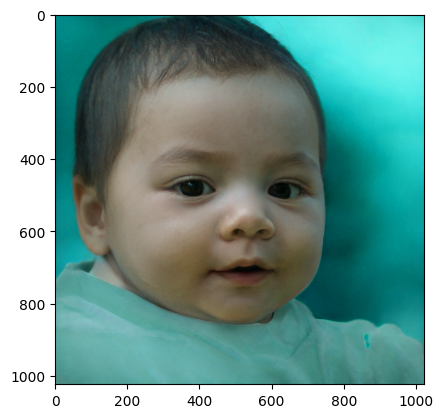

In [75]:
plt.imshow(imgs[0].permute(1, 2, 0) * 0.5 + 0.5)

In [73]:
images = inferencer.to_image(example_latent.cuda())

In [74]:
images.shape

torch.Size([4, 3, 1024, 1024])

In [123]:
from src.models.styleclip.global_directions.utils import GetBoundary, GetDt

text_prompt = 'face with big eyes'
neutral_text = 'face with eyes'
classnames = [text_prompt, neutral_text]
dt = GetDt(classnames, inferencer.clip_model)

boundary, _ = GetBoundary(inferencer.fs3, dt, inferencer.manipulator,
                          threshold=inferencer.beta)

0.2808
num of channels being manipulated: 271


In [124]:
boundary.__len__(), boundary[0].shape

(26, (512,))

In [125]:
type(inferencer.manipulator.manipulate_layers)

NoneType

In [126]:
manipulated['conv1_resolution_4'].shape

torch.Size([4, 512])

In [103]:
boundary[i].shape

(512,)

In [108]:
inferencer.manipulator.alpha

[3]

In [127]:
from copy import deepcopy

s_latent = inferencer.manipulator.G.synthesis.W2S(example_latent.cuda())

manipulated = deepcopy(s_latent)

for i in range(len(inferencer.manipulator.s_names)):
    key = inferencer.manipulator.s_names[i]
    manipulated[key] += inferencer.manipulator.alpha[0] * torch.from_numpy(boundary[i]).to(manipulated[key])

In [128]:
with torch.no_grad():
    imgs = inferencer.manipulator.G.synthesis(
        None, encoded_styles=manipulated, noise_mode="const"
    ).detach().cpu()

In [129]:
imgs.shape

torch.Size([4, 3, 1024, 1024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


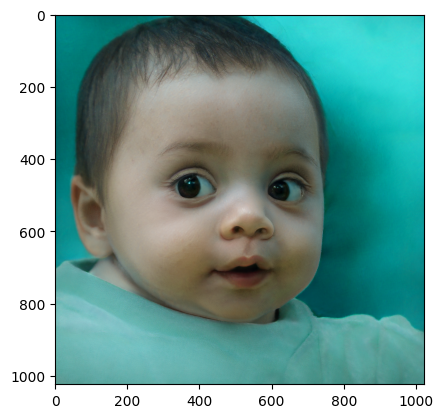

In [130]:
plt.imshow(imgs[0].permute(1, 2, 0) * 0.5 + 0.5)

In [132]:
example_latent.shape

torch.Size([4, 18, 512])

In [136]:
gen_images, src_images = inferencer(example_latent.cuda(), 'face with red hair', 'face with hair')

0.5444
num of channels being manipulated: 59


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'face with red hair')

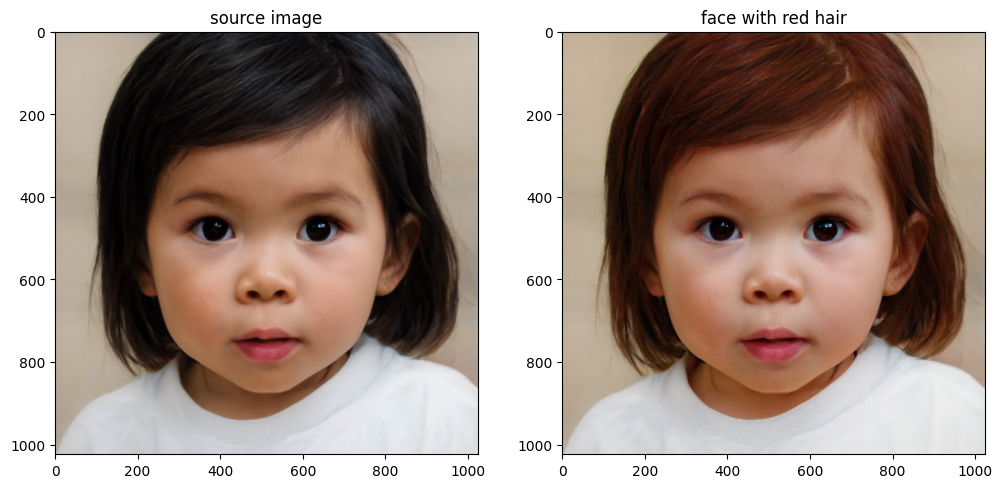

In [139]:
import random

ind = random.randint(0, 4)

src_image = src_images[ind]
gen_image = gen_images[ind]

_, axs = plt.subplots(ncols=2, figsize=(12, 6))

axs[0].imshow(
    src_image.permute(1, 2, 0) * 0.5 + 0.5
)
axs[0].set_title('source image')

axs[1].imshow(
    gen_image.permute(1, 2, 0) * 0.5 + 0.5
)
axs[1].set_title('face with red hair')

In [141]:
w_latents[58000:].shape

(12000, 18, 512)